# MEMM project: NaCL umbrella sampling

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyemma
import mdshare

mpl.rcParams.update({'font.size': 14})

/Users/fab/opt/miniconda3/lib/python3.7/site-packages/mdshare/repository.py:53: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = load(fh)


Now it is your turn. Below you will find a dataset of a Na-Cl-dimer in TiP3P water; the dataset includes Na-Cl-distance timeseries from NN biased simulations which incrementally pull the ions apart and 20 unbiased simulations started at a Na-Cl-distance of approximately 3.5 Angstrom. The umbrella sampling parameters and the kT value are also given.

All distances in the dataset are in Angstrom, energies in kcal/mol, and the trajectory timestep is 1 ps.

In [4]:
with np.load(mdshare.fetch('pyemma-tutorial-us-nacl.npz', working_directory='data')) as fh:
    us_trajs = [fh['us_traj_%03d' % i] for i in range(60)]
    us_centers = fh['us_centers'].tolist()
    us_force_constants = fh['us_force_constants'].tolist()
    md_trajs = [fh['md_traj_%03d' % i] for i in range(20)]
    kT = float(fh['kT'])

In [15]:
cl = pyemma.coordinates.cluster_regspace(us_trajs, dmin=0.1)
us_dtrajs = cl.dtrajs

### Step 1

You can experiment with visualizations of the raw data or jump straight into the discretization.

Text(0.5,0,'order parameter / a.u.')

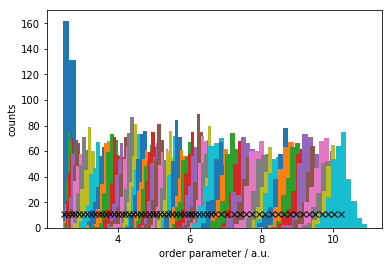

In [43]:
for us_traj in us_trajs:
    plt.hist(us_traj)
plt.plot(us_centers, np.ones_like(us_centers)+10, 'xk')
plt.ylabel('counts')
plt.xlabel('order parameter / a.u.')

### Step 2
Try to apply WHAM to get a quick estimate of the stationary properties of the system. Try only the biased data or use both biased and unbiased.

In [ ]:
wham = pyemma.thermo.estimate_umbrella_sampling(
    us_trajs, us_dtrajs, us_centers, us_force_constants,
    maxiter=100000, maxerr=1.0E-15, save_convergence_info=50, estimator='wham')

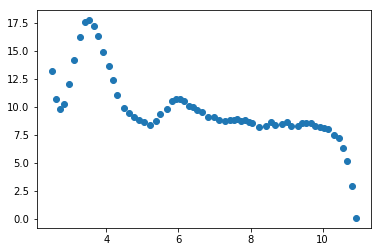

In [44]:
plt.plot(cl.clustercenters, wham.f, 'o')

In [47]:
#plt.plot(wham.f_therm, 'o')

### Step 3
Now apply DTRAM and estimate the kinetic properties of the system. Remember: kinetics require unbiased data!

In [25]:
md_dtrajs = cl.assign(md_trajs)

In [60]:
dtram = pyemma.thermo.estimate_umbrella_sampling(
    us_trajs, us_dtrajs, us_centers, us_force_constants,
    md_trajs = md_trajs, md_dtrajs=md_dtrajs,
    lag = 10,
    maxiter=100000, maxerr=1.0E-15, save_convergence_info=50, estimator='dtram')

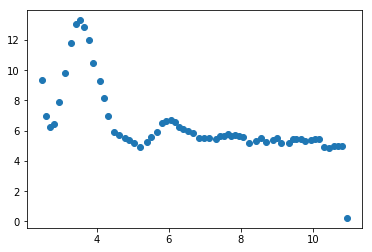

In [54]:
plt.plot(cl.clustercenters, dtram.f, 'o')

In [77]:
dmsm = dtram.msm

In [80]:
dmsm.pcca(2)

PCCA(P=array([[2.20058e-12, 9.91231e-03, ..., 0.00000e+00, 1.84968e-02],
       [1.03379e-02, 1.40102e-01, ..., 0.00000e+00, 0.00000e+00],
       ...,
       [0.00000e+00, 0.00000e+00, ..., 1.88587e-12, 6.52643e-01],
       [2.56567e-05, 0.00000e+00, ..., 5.53387e-03, 9.17458e-01]]),
   m=2)

In [85]:
print(dmsm.pi.shape)
print(cl.clustercenters.shape)
print(dmsm.metastable_assignments.shape)
print(dmsm.active_set.shape)

(64,)
(64, 1)
(63,)
(63,)


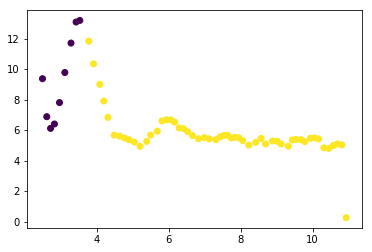

In [86]:
plt.scatter(cl.clustercenters[dmsm.active_set], -np.log(dmsm.pi[dmsm.active_set]), c=dmsm.metastable_assignments)

In [87]:
dmsm.mfpt(dmsm.metastable_sets[0], dmsm.metastable_sets[1])

32.05706704456859

In [88]:
dmsm.mfpt(dmsm.metastable_sets[1], dmsm.metastable_sets[0])

6141.310945361422

### Step 4
We have unbiased data, so let's build a regular MSM and compare with the MEMM results.

In [26]:
md_dtrajs = cl.assign(md_trajs)

In [27]:
its = pyemma.msm.its(md_dtrajs, lags=100)

19-02-20 07:24:10 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[18] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


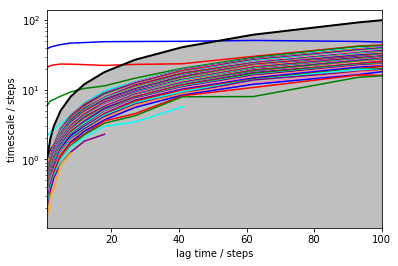

In [28]:
pyemma.plots.plot_implied_timescales(its)

In [30]:
msm = pyemma.msm.estimate_markov_model(md_dtrajs, 10)

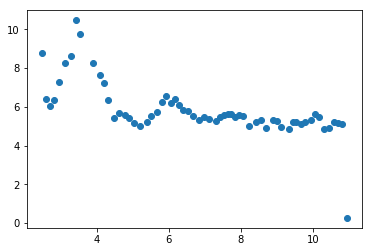

In [37]:
plt.plot(cl.clustercenters[msm.active_set], -np.log(msm.pi), 'o')

In [56]:
msm.pcca(2)

PCCA(P=array([[0.00000e+00, 1.10731e-02, ..., 0.00000e+00, 2.02022e-02],
       [1.22155e-02, 1.59091e-01, ..., 0.00000e+00, 0.00000e+00],
       ...,
       [0.00000e+00, 0.00000e+00, ..., 0.00000e+00, 6.56846e-01],
       [4.71242e-05, 0.00000e+00, ..., 5.18285e-03, 9.17310e-01]]),
   m=2)

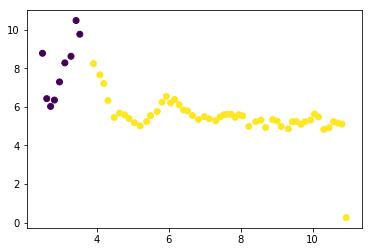

In [57]:
plt.scatter(cl.clustercenters[msm.active_set], -np.log(msm.pi), c=msm.metastable_assignments)

In [58]:
msm.mfpt(msm.metastable_sets[0], msm.metastable_sets[1])

32.81444040948324

In [59]:
msm.mfpt(msm.metastable_sets[1], msm.metastable_sets[0])

4979.866893115257

In [89]:
bmsm = pyemma.msm.bayesian_markov_model(md_dtrajs, lag=10)

In [93]:
bmsm.sample_conf('mfpt', msm.metastable_sets[0], msm.metastable_sets[1])

(29.176745059627443, 38.29857526103458)

In [94]:
bmsm.sample_conf('mfpt', msm.metastable_sets[1], msm.metastable_sets[0])

(3937.421210467341, 8336.608212657964)